# \[STBDA\] 06wk: keras

김보람  
2023-06-23

> 해당 강의노트는 전북대학교 최규빈교수님
> [STBDA2022](https://guebin.github.io/STBDA2022/) 자료임

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

2023-06-23 14:44:48.422443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [2]:
tnp.experimental_enable_numpy_behavior()

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

### $x \to \hat{y}$ 가 되는 과정을 그림으로 그리기

`-` 단순회귀분석의 예시 -
$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_i, \quad i=1,2,\dots,n$

(표현1)

In [4]:
#collapse
gv('''
    "1" -> "β̂₀ + xₙ*β̂₁,    bias=False"[label="* β̂₀"]
    "xₙ" -> "β̂₀ + xₙ*β̂₁,    bias=False"[label="* β̂₁"]
    "β̂₀ + xₙ*β̂₁,    bias=False" -> "ŷₙ"[label="identity"]

    "." -> "...................................."[label="* β̂₀"]
    ".." -> "...................................."[label="* β̂₁"]
    "...................................." -> "..."[label=" "]

    "1 " -> "β̂₀ + x₂*β̂₁,    bias=False"[label="* β̂₀"]
    "x₂" -> "β̂₀ + x₂*β̂₁,    bias=False"[label="* β̂₁"]
    "β̂₀ + x₂*β̂₁,    bias=False" -> "ŷ₂"[label="identity"]

    "1  " -> "β̂₀ + x₁*β̂₁,    bias=False"[label="* β̂₀"]
    "x₁" -> "β̂₀ + x₁*β̂₁,    bias=False"[label="* β̂₁"]
    "β̂₀ + x₁*β̂₁,    bias=False" -> "ŷ₁"[label="identity"]
''')


`-` 표현1의 소감? - 교수님이 고생해서 만든것 같음 - 그런데 그냥 다
똑같은 그림의 반복이라 사실 고생한 의미가 없음.

(표현2)

`-` 그냥 아래와 같이 그리고 “모든 $i=1,2,3,\dots,n$에 대하여
$\hat{y}_i$을 아래의 그림과 같이 그린다”고 하면 될것 같다.

In [5]:
#collapse
gv('''
    "1" -> "β̂₀ + xᵢ*β̂₁,    bias=False"[label="* β̂₀"]
    "xᵢ" -> "β̂₀ + xᵢ*β̂₁,    bias=False"[label="* β̂₁"]
    "β̂₀ + xᵢ*β̂₁,    bias=False" -> "ŷᵢ"[label="identity"]

''')


(표현3)

`-` 그런데 “모든 $i=1,2,3,\dots,n$에 대하여 $\hat{y}_i$을 아래의 그림과
같이 그린다” 라는 언급자체도 반복할 필요가 없을 것 같다. (어차피 당연히
그럴테니까) 그래서 단순히 아래와 같이 그려도 무방할듯 하다.

In [6]:
gv('''
    "1" -> "β̂₀ + x*β̂₁,    bias=False"[label="* β̂₀"]
    "x" -> "β̂₀ + x*β̂₁,    bias=False"[label="* β̂₁"]
    "β̂₀ + x*β̂₁,    bias=False" -> "ŷ"[label="identity"]

''')


(표현4)

`-` 위의 모델은 아래와 같이 쓸 수 있다. ($\beta_0$를 바이어스로 표현)

In [7]:
#collapse
gv('''
"x" -> "x*β̂₁,    bias=True"[label="*β̂₁"] ;
"x*β̂₁,    bias=True" -> "ŷ"[label="indentity"] ''')


-   실제로는 이 표현을 많이 사용함

(표현5)

`-` 벡터버전으로 표현하면 아래와 같다. 이 경우에는 ${\bf X}=[1,x]$에
포함된 1이 bias의 역할을 해주므로 `bias = False` 임.

In [8]:
#collapse
gv('''
"X" -> "X@β̂,    bias=False"[label="@β̂"] ;
"X@β̂,    bias=False" -> "ŷ"[label="indentity"] ''')


-   저는 이걸 좋아해요

(표현6)

`-` 딥러닝에서는 $\hat{\boldsymbol{\beta}}$ 대신에 $\hat{{\bf W}}$을
라고 표현한다.

In [9]:
#collapse
gv('''
"X" -> "X@Ŵ,    bias=False"[label="@Ŵ"] ;
"X@Ŵ,    bias=False" -> "ŷ"[label="identity"] ''')


`-` 실제로는 표현4 혹은 표현5를 외우면 된다.

### Layer의 개념

`-` (표현4) 혹은 (표현5)의 그림은 레이어로 설명할 수 있다.

`-` 레이어는 항상 아래와 같은 규칙을 가진다. - 첫 동그라미는 레이어의
입력이다. - 첫번째 화살표는 선형변환을 의미한다. - 두번째 동그라미는
선형변환의 결과이다. (이때 bias가 false인지 true인지에 따라서 실제
수식이 조금 다름) - 두번째 화살표는 두번째 동그라미에 어떠한 함수 $f$를
취하는 과정을 의미한다. (우리의 그림에서는 $f(x)=x$) - 세번째 동그라미는
레이어의 최종출력이다.

`-` 엄청 복잡한데, 결국 레이어를 만들때 위의 그림들을 의미하도록 하려면
아래의 4개의 요소만 필요하다. 1. 레이어의 입력차원 2. 선형변환의 결과로
얻어지는 차원 3. 선형변환에서 바이어스를 쓸지? 안쓸지? 4. 함수 $f$

`-` 주목: 1,2가 결정되면 자동으로 $\hat{{\bf W}}$의 차원이 결정된다.

(예시) - 레이어의 입력차원=2, 선형변환의 결과로 얻어지는 차원=1:
$\hat{\bf W}$는 (2,1) 매트릭스 - 레이어의 입력차원=20, 선형변환의 결과로
얻어지는 차원=5: $\hat{\bf W}$는 (20,5) 매트릭스 - 레이어의 입력차원=2,
선형변환의 결과로 얻어지는 차원=50: $\hat{\bf W}$는 (2,50) 매트릭스

`-` 주목2: 이중에서 절대 생략불가능 것은 “2. 선형변환의 결과로 얻어지는
차원” 이다. - 레이어의 입력차원: 실제 레이어에 데이터가 들어올 때
데이터의 입력차원을 컴퓨터 스스로 체크하여 $\hat{\bf W}$의 차원을 결정할
수 있음. - 바이어스를 쓸지? 안쓸지? 기본적으로 쓴다고 가정한다. - 함수
$f$: 기본적으로 항등함수를 가정하면 된다.

### Keras를 이용한 풀이

`-` 기본뼈대: net생성 $\to$ add(layer) $\to$ compile(opt,loss) $\to$
fit(data,epochs)

`-` 데이터정리

$${\bf y}\approx 2.5 +4*x$$

In [10]:
tnp.random.seed(43052)
N= 200
x= tnp.linspace(0,1,N)
epsilon= tnp.random.randn(N)*0.5
y= 2.5+4*x +epsilon

In [11]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)

#### 풀이1: 스칼라버전

(0단계) 데이터정리

In [12]:
y=y.reshape(N,1)
x=x.reshape(N,1)
x.shape,y.shape

(1단계) net 생성

In [13]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [14]:
layer = tf.keras.layers.Dense(1)
# 입력차원? 데이터를 넣어보고 결정, 바이어스=디폴드값을 쓰겠음 (use_bias=true), 함수도 디폴트값을 쓰겠음 (f(x)=x)
net.add(layer)

(3단계) net.compile(opt,loss_fn)

In [15]:
net.compile(tf.keras.optimizers.SGD(0.1), tf.keras.losses.MSE)

(4단계) net.fit(x,y,epochs)

In [16]:
net.fit(x,y,epochs=1000,verbose=0,batch_size=N) # batch_size=N 일 경우에 경사하강법이 적용, batch_size!=N 이면 확률적 경사하강법 적용

(결과확인)

In [17]:
net.weights

#### 풀이2: 벡터버전

(0단계) 데이터정리

In [18]:
X.shape,y.shape

(1단계) net 생성

In [19]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [20]:
layer = tf.keras.layers.Dense(1,use_bias=False)
net.add(layer)

(3단계) net.compile(opt,loss_fn)

In [21]:
net.compile(tf.keras.optimizers.SGD(0.1), tf.keras.losses.MSE)

(4단계) net.fit(x,y,epochs)

In [22]:
net.fit(X,y,epochs=1000,verbose=0,batch_size=N) # batch_size=N 일 경우에 경사하강법이 적용, batch_size!=N 이면 확률적 경사하강법 적용

(결과확인)

In [23]:
net.weights

#### 잠시문법정리

`-` 잠깐 Dense layer를 만드는 코드를 정리해보자.

1.  아래는 모두 같은 코드이다.

-   tf.keras.layers.Dense(1)
-   tf.keras.layers.Dense(units=1)
-   tf.keras.layers.Dense(units=1,activation=‘linear’) // identity 가 더
    맞는것 같은데..
-   tf.keras.layers.Dense(units=1,activation=‘linear’,use_bias=True)

1.  아래의 코드1,2는 (1)의 코드들과 살짝 다른코드이다. (코드1과 코드2는
    같은코드임)

-   tf.keras.layers.Dense(1,input_dim=2) \# 코드1
-   tf.keras.layers.Dense(1,input_shape=(2,)) \# 코드2

1.  아래는 사용불가능한 코드이다.

-   tf.keras.layers.Dense(1,input_dim=(2,)) \# 코드1
-   tf.keras.layers.Dense(1,input_shape=2) \# 코드2

`-` 왜 input_dim이 필요한가?

In [25]:
net1 = tf.keras.Sequential()
net1.add(tf.keras.layers.Dense(1,use_bias=False))

In [26]:
net2 = tf.keras.Sequential()
net2.add(tf.keras.layers.Dense(1,use_bias=False,input_dim=2))

In [27]:
net1.weights

In [28]:
net2.weights

In [29]:
net1.summary()

In [30]:
net2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________

#### 풀이3: 스칼라버전, 임의의 초기값을 설정

(0단계) 데이터정리

In [31]:
y=y.reshape(N,1)
x=x.reshape(N,1)
x.shape,y.shape

(1단계) net생성

In [32]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [33]:
layer = tf.keras.layers.Dense(1,input_dim=1)

In [34]:
net.add(layer)

------------------------------------------------------------------------

***초기값을 설정***

In [38]:
net.weights

-   input_dim=1로 설정해서 weights값이 찍힘

In [39]:
net.get_weights()

-   weight, bias순으로 출력

In [40]:
net.set_weights?

-   layer_b.set_weights(layer_a.get_weights()) 와 같은방식으로 쓴다는
    것이군?

`-` 한번따라해보자.

In [41]:
_w = net.get_weights()
_w

In [42]:
type(_w)

-   길이가 2인 리스트이고, 각 원소는 numpy array 임

In [43]:
net.set_weights(
    [np.array([[10.0]],dtype=np.float32), # weight, β1_hat
     np.array([-5.0],dtype=np.float32)] # bias, β0_hat
)

In [44]:
net.weights

------------------------------------------------------------------------

(3단계) net.compile()

In [45]:
net.compile(tf.keras.optimizers.SGD(0.1),tf.losses.MSE)

(4단계) net.fit()

In [46]:
net.fit(x,y,epochs=1000,verbose=0,batch_size=N)

결과확인

In [47]:
net.weights

#### 풀이4: 벡터버전, 임의의 초기값을 설정

(0단계) 데이터정리

In [48]:
X.shape, y.shape

(1단계) net생성

In [49]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [50]:
layer = tf.keras.layers.Dense(1,use_bias=False,input_dim=2)

-   위으 X.shape이 \[200,2\]니까 `input_dim=2` 로 해준다.

In [51]:
net.add(layer)

------------------------------------------------------------------------

***초기값을 설정하자***

In [55]:
net.set_weights([np.array([[ -5.0],[10.0]], dtype=np.float32)])

In [56]:
net.get_weights()

------------------------------------------------------------------------

(3단계) net.compile()

In [57]:
net.compile(tf.keras.optimizers.SGD(0.1), tf.losses.MSE)

(4단계) net.fit()

In [58]:
net.fit(X,y,epochs=1000,verbose=0,batch_size=N)

In [59]:
net.weights

`-` 사실 실전에서는 초기값을 설정할 필요가 별로 없음.

#### 풀이5: 벡터버전 사용자정의 손실함수

(0단계) 데이터정리

In [60]:
X.shape, y.shape

(1단계) net생성

In [61]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [62]:
layer = tf.keras.layers.Dense(1,use_bias=False)

In [63]:
net.add(layer)

(3단계) net.compile()

In [64]:
loss_fn = lambda y,yhat: (y-yhat).T @ (y-yhat) / N

In [65]:
net.compile(tf.keras.optimizers.SGD(0.1), loss_fn)

(4단계) net.fit()

In [66]:
net.fit(X,y,epochs=1000,verbose=0,batch_size=N)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089

In [67]:
net.weights

#### 풀이6: 벡터버전, net.compile의 옵션으로 손실함수 지정

(0단계) 데이터정리

In [68]:
X.shape, y.shape

(1단계) net생성

In [69]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [70]:
net.add(tf.keras.layers.Dense(1,use_bias=False))

(3단계) net.compile()

In [72]:
net.compile(tf.keras.optimizers.SGD(0.1), loss='mse')

(4단계) net.fit()

In [73]:
net.fit(X,y,epochs=1000,verbose=0,batch_size=N)

In [74]:
net.weights

#### 풀이7: 벡터버전, net.compile의 옵션으로 손실함수 지정 + 옵티마이저 지정

(0단계) 데이터정리

In [75]:
X.shape, y.shape

(1단계) net생성

In [76]:
net = tf.keras.Sequential()

(2단계) net.add(layer)

In [77]:
net.add(tf.keras.layers.Dense(1,use_bias=False))

(3단계) net.compile()

In [78]:
net.compile(optimizer='sgd', loss='mse')
#net.optimizer.lr = tf.Variable(0.1,dtype=tf.float32)
#net.optimizer.lr = 0.1

In [81]:
net.optimizer.lr

-   그 전풀이에서는 $\alpha=0.1$로 설정되어 있으나, 위 compile의 옵션
    optimizer=’sgd’에서는 0.01이 기본으로 설정되어 있어

(4단계) net.fit()

In [79]:
net.fit(X,y,epochs=5000,verbose=0,batch_size=N)

-   학습률 건드리지 말고 그냥 epcohs을 늘려주자.

In [80]:
net.weights

### 여러가지 회귀모형의 적합과 학습과정의 모니터링

#### 예제1

model: $y_i \approx \beta_0 +\beta_1 x_i$

In [82]:
np.random.seed(43052)
N= 100
x= np.random.randn(N)
epsilon = np.random.randn(N)*0.5
y= 2.5+4*x +epsilon

In [83]:
X= np.stack([np.ones(N),x],axis=1)
y= y.reshape(N,1)

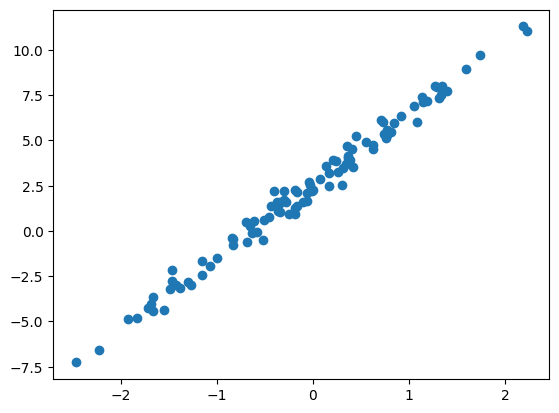

In [84]:
plt.plot(x,y,'o') # 관측한 자료

In [86]:
beta_hat = np.array([-3,-2]).reshape(2,1)

-   위의 -3,-2는 그냥 이렇지 않을까? 하고 넣어본 임의의 숫자.

In [87]:
yhat = X@beta_hat

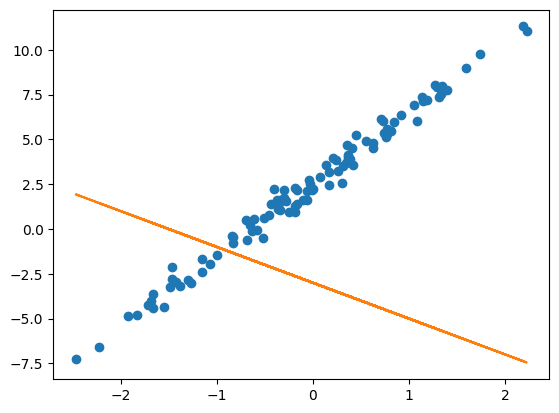

In [88]:
plt.plot(x,y,'o')
plt.plot(x,yhat.reshape(-1),'-')

더 좋은 적합선을 얻기위해서!

In [89]:
slope = (2*X.T@X@beta_hat - 2*X.T@y)/ N
beta_hat2 = beta_hat - 0.1*slope
yhat2 = X@beta_hat2

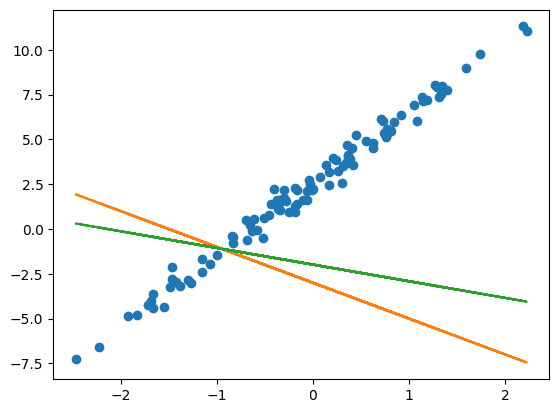

In [90]:
plt.plot(x,y,'o')
plt.plot(x,yhat.reshape(-1),'-')
plt.plot(x,yhat2.reshape(-1),'-')

초록색이 좀 더 나아보인다.

In [93]:
beta_hat = np.array([-3,-2]).reshape(2,1)
beta_hats = beta_hat # beta_hats = beta_hat.copy() 가 더 안전한 코드입니다.
for i in range(1,30):
    yhat = X@beta_hat
    slope = (2*X.T@X@beta_hat - 2*X.T@y) / N
    beta_hat = beta_hat - 0.1*slope # 0.1은 적당, 0.3은 쪼금빠르지만 그래도 적당, 0.9는 너무 나간것같음, 1.0 은 수렴안함, 1.2
    beta_hats = np.concatenate([beta_hats,beta_hat],axis=1)

In [94]:
beta_hats

In [95]:
b0hats = beta_hats[0].tolist()
b1hats = beta_hats[1].tolist()

In [97]:
np.linalg.inv(X.T@X) @ X.T @ y

-   β0, β1에 대한 최솟값

In [96]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [99]:
fig = plt.figure(); fig.set_figheight(5); fig.set_figwidth(12)

In [100]:
ax1= fig.add_subplot(1,2,1)
ax2= fig.add_subplot(1,2,2,projection='3d')
# ax1: 왼쪽그림
ax1.plot(x,y,'o')
line, = ax1.plot(x,b0hats[0] + b1hats[0]*x)
# ax2: 오른쪽그림
β0,β1 = np.meshgrid(np.arange(-6,11,0.25),np.arange(-6,11,0.25),indexing='ij')
β0=β0.reshape(-1)
β1=β1.reshape(-1)
loss_fn = lambda b0,b1: np.sum((y-b0-b1*x)**2)
loss = list(map(loss_fn, β0,β1))
ax2.scatter(β0,β1,loss,alpha=0.02)
ax2.scatter(2.5451404,3.94818596,loss_fn(2.5451404,3.94818596),s=200,marker='*')

def animate(i):
    line.set_ydata(b0hats[i] + b1hats[i]*x)
    ax2.scatter(b0hats[i],b1hats[i],loss_fn(b0hats[i],b1hats[i]),color="grey")

ani = animation.FuncAnimation(fig,animate,frames=30)
ani

#### 예제2

model: $y_i \approx \beta_0 +\beta_1 e^{-x_i}$

In [101]:
np.random.seed(43052)
N= 100
x= np.linspace(-1,1,N)
epsilon = np.random.randn(N)*0.5
y= 2.5+4*np.exp(-x) +epsilon

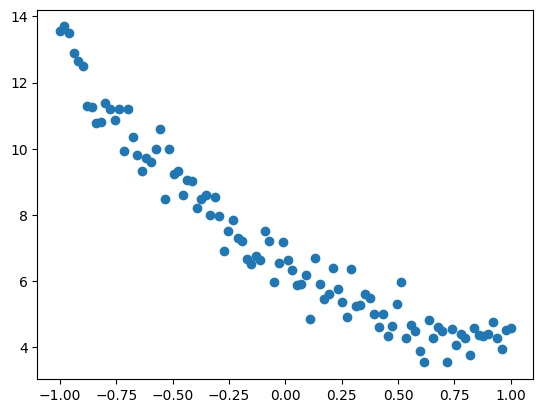

In [102]:
plt.plot(x,y,'o')

In [103]:
X= np.stack([np.ones(N),np.exp(-x)],axis=1)
y= y.reshape(N,1)

In [104]:
beta_hat = np.array([-3,-2]).reshape(2,1)
beta_hats = beta_hat.copy() # shallow copy, deep copy <--- 여름 방학 특강
for i in range(1,30):
    yhat = X@beta_hat
    slope = (2*X.T@X@beta_hat - 2*X.T@y) /N
    beta_hat = beta_hat - 0.05*slope
    beta_hats = np.concatenate([beta_hats,beta_hat],axis=1)

In [105]:
beta_hats

In [106]:
b0hats= beta_hats[0].tolist()
b1hats= beta_hats[1].tolist()

In [107]:
np.linalg.inv(X.T@X)@X.T@y

In [108]:
fig = plt.figure(); fig.set_figheight(5); fig.set_figwidth(12)

In [109]:
ax1= fig.add_subplot(1,2,1)
ax2= fig.add_subplot(1,2,2,projection='3d')
# ax1: 왼쪽그림
ax1.plot(x,y,'o')
line, = ax1.plot(x,b0hats[0] + b1hats[0]*np.exp(-x))
# ax2: 오른쪽그림
β0,β1 = np.meshgrid(np.arange(-6,11,0.25),np.arange(-6,11,0.25),indexing='ij')
β0=β0.reshape(-1)
β1=β1.reshape(-1)
loss_fn = lambda b0,b1: np.sum((y-b0-b1*np.exp(-x))**2)
loss = list(map(loss_fn, β0,β1))
ax2.scatter(β0,β1,loss,alpha=0.02)
ax2.scatter(2.46307644,3.99681332,loss_fn(2.46307644,3.99681332),s=200,marker='*')

def animate(i):
    line.set_ydata(b0hats[i] + b1hats[i]*np.exp(-x))
    ax2.scatter(b0hats[i],b1hats[i],loss_fn(b0hats[i],b1hats[i]),color="grey")

ani = animation.FuncAnimation(fig,animate,frames=30)
ani

#### 예제3

model: $y_i \approx \beta_0 +\beta_1 e^{-x_i} + \beta_2 \cos(5x_i)$

In [110]:
np.random.seed(43052)
N= 100
x= np.linspace(-1,1,N)
epsilon = np.random.randn(N)*0.5
y= 2.5+4*np.exp(-x) + 5*np.cos(5*x) + epsilon

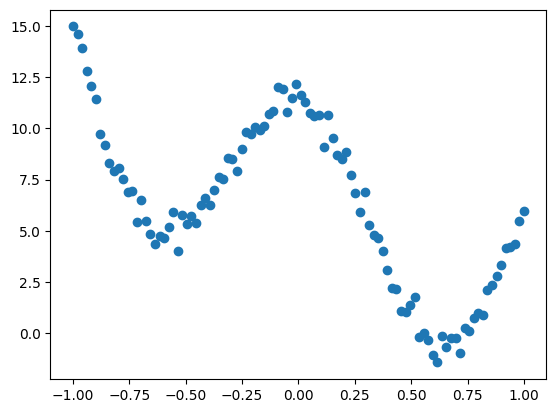

In [111]:
plt.plot(x,y,'o')

In [112]:
X=np.stack([np.ones(N),np.exp(-x),np.cos(5*x)],axis=1)
y=y.reshape(N,1)

In [113]:
beta_hat = np.array([-3,-2,-1]).reshape(3,1)
beta_hats = beta_hat.copy()
for i in range(1,30):
    yhat = X@beta_hat
    slope = (2*X.T@X@beta_hat -2*X.T@y) /N
    beta_hat = beta_hat - 0.1 * slope
    beta_hats= np.concatenate([beta_hats,beta_hat],axis=1)

In [114]:
beta_hats

In [115]:
b0hats,b1hats,b2hats = beta_hats

In [116]:
np.linalg.inv(X.T@X) @ X.T @ y

In [117]:
fig = plt.figure(); fig.set_figheight(5); fig.set_figwidth(12)

In [118]:
ax1= fig.add_subplot(1,2,1)
ax2= fig.add_subplot(1,2,2,projection='3d')
# ax1: 왼쪽그림
ax1.plot(x,y,'o')
line, = ax1.plot(x,b0hats[0] + b1hats[0]*np.exp(-x) + b2hats[0]*np.cos(5*x))
# ax2: 오른쪽그림
# β0,β1 = np.meshgrid(np.arange(-6,11,0.25),np.arange(-6,11,0.25),indexing='ij')
# β0=β0.reshape(-1)
# β1=β1.reshape(-1)
# loss_fn = lambda b0,b1: np.sum((y-b0-b1*np.exp(-x))**2)
# loss = list(map(loss_fn, β0,β1))
# ax2.scatter(β0,β1,loss,alpha=0.02)
# ax2.scatter(2.46307644,3.99681332,loss_fn(2.46307644,3.99681332),s=200,marker='*')

def animate(i):
    line.set_ydata(b0hats[i] + b1hats[i]*np.exp(-x) + b2hats[i]*np.cos(5*x))
    # ax2.scatter(b0hats[i],b1hats[i],loss_fn(b0hats[i],b1hats[i]),color="grey")

ani = animation.FuncAnimation(fig,animate,frames=30)
ani

#### 예제3: 케라스로 해보자!

model: $y_i \approx \beta_0 +\beta_1 e^{-x_i} + \beta_2 \cos(5x_i)$

In [119]:
np.random.seed(43052)
N= 100
x= np.linspace(-1,1,N)
epsilon = np.random.randn(N)*0.5
y= 2.5+4*np.exp(-x) + 5*np.cos(5*x) + epsilon

In [120]:
X=np.stack([np.ones(N),np.exp(-x),np.cos(5*x)],axis=1)
y=y.reshape(N,1)

In [121]:
net = tf.keras.Sequential() # 1: 네트워크 생성
net.add(tf.keras.layers.Dense(1,use_bias=False)) # 2: add layer
net.compile(tf.optimizers.SGD(0.1), loss='mse') # 3: compile
net.fit(X,y,epochs=30, batch_size=N) # 4: fit

Epoch 1/30
1/1 [==============================] - 0s 268ms/step - loss: 28.0844
Epoch 2/30
1/1 [==============================] - 0s 1ms/step - loss: 13.7046
Epoch 3/30
1/1 [==============================] - 0s 1ms/step - loss: 9.4655
Epoch 4/30
1/1 [==============================] - 0s 1ms/step - loss: 7.5460
Epoch 5/30
1/1 [==============================] - 0s 1ms/step - loss: 6.2784
Epoch 6/30
1/1 [==============================] - 0s 1ms/step - loss: 5.2871
Epoch 7/30
1/1 [==============================] - 0s 1ms/step - loss: 4.4707
Epoch 8/30
1/1 [==============================] - 0s 1ms/step - loss: 3.7893
Epoch 9/30
1/1 [==============================] - 0s 1ms/step - loss: 3.2186
Epoch 10/30
1/1 [==============================] - 0s 1ms/step - loss: 2.7401
Epoch 11/30
1/1 [==============================] - 0s 1ms/step - loss: 2.3389
Epoch 12/30
1/1 [==============================] - 0s 1ms/step - loss: 2.0023
Epoch 13/30
1/1 [==============================] - 0s 1ms/step - loss

In [122]:
net.weights

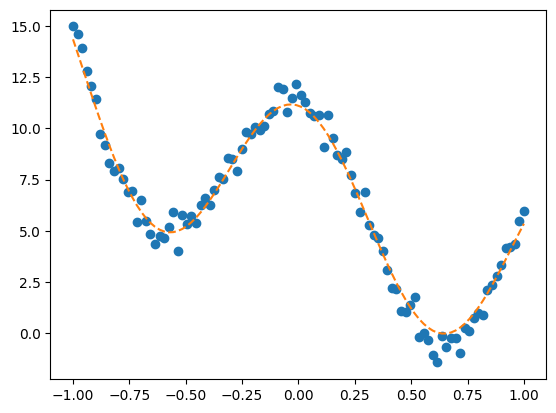

In [123]:
plt.plot(x,y,'o')
plt.plot(x,(X@net.weights).reshape(-1),'--')

### 숙제

#### 예제2: 케라스를 이용하여 아래를 만족하는 적절한 $\beta_0$와 $\beta_1$을 구하라. 적합결과를 시각화하라. (애니메이션 시각화 X)

model: $y_i \approx \beta_0 +\beta_1 e^{-x_i}$

In [124]:
np.random.seed(43052)
N= 100
x= np.linspace(-1,1,N)
epsilon = np.random.randn(N)*0.5
y= 2.5+4*np.exp(-x) +epsilon

In [125]:
X=np.stack([np.ones(N),np.exp(-x)],axis=1)
y=y.reshape(N,1)

In [126]:
net = tf.keras.Sequential() # 1: 네트워크 생성
net.add(tf.keras.layers.Dense(1,use_bias=False)) # 2: add layer
net.compile(tf.optimizers.SGD(0.1), loss='mse') # 3: compile
net.fit(X,y,epochs=30, verbose=0, batch_size=N) # 4: fit

In [127]:
net.weights

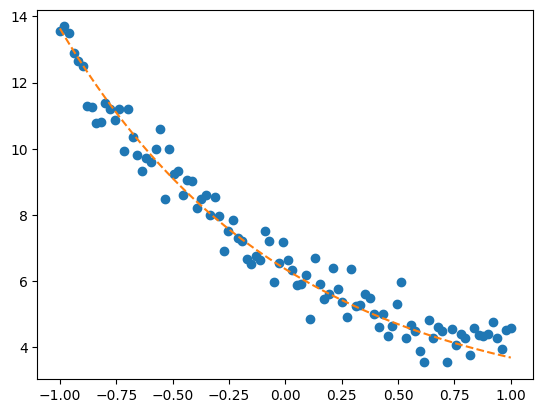

In [128]:
plt.plot(x,y,'o')
plt.plot(x,(X@net.weights).reshape(-1),'--')